<a href="https://colab.research.google.com/github/hjangir080/EmotionAwareMusicGeneration/blob/main/v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 4

# Package Installation & Imports

In [1]:
!pip install transformers torch numpy librosa soundfile matplotlib IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os
import requests
from tqdm import tqdm
import io

# Emotion Extraction Module

In [3]:
class EmotionExtractionModule(nn.Module):
    """Module for extracting emotional information from literary text"""
    def __init__(self, model_name="roberta-base", num_emotions=8, device=None):
        super(EmotionExtractionModule, self).__init__()

        # Load pre-trained language model for emotion analysis
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.model = RobertaModel.from_pretrained(model_name)

        # Emotion classifier head
        self.emotion_classifier = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_emotions),
            nn.Sigmoid()  # Multiple emotions can be present simultaneously
        )

        # Define the emotion categories
        self.emotion_categories = [
            "joy", "sadness", "anger", "fear",
            "tenderness", "excitement", "calmness", "tension"
        ]

        # Sliding window parameters for analyzing longer texts
        self.window_size = 512  # Max tokens per window
        self.stride = 256  # Overlap between windows

        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        self.emotion_classifier = self.emotion_classifier.to(self.device)

    def forward(self, text, return_attention=False):
        """
        Extract emotion scores from text
        Returns emotion scores and attention weights for visualization
        """
        # For longer texts, break into overlapping chunks
        if isinstance(text, str):
            text = [text]

        all_emotion_scores = []
        all_attention_weights = []

        for t in text:
            # Break long text into chunks with sliding window
            chunks = self._create_text_chunks(t)
            chunk_emotions = []
            chunk_attentions = []

            for chunk in chunks:
                # Tokenize with attention mask
                inputs = self.tokenizer(chunk, return_tensors="pt",
                                      padding=True, truncation=True, max_length=self.window_size)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

                # Get model outputs
                with torch.no_grad():
                    outputs = self.model(**inputs, output_attentions=return_attention)

                # Use [CLS] token representation for classification
                sequence_output = outputs.last_hidden_state[:, 0, :]
                emotions = self.emotion_classifier(sequence_output)

                # Store results
                chunk_emotions.append(emotions)

                # Extract attention patterns only if requested
                if return_attention:
                    attentions = outputs.attentions[-1].mean(dim=1)  # Average over heads in last layer
                    chunk_attentions.append(attentions)

            # Combine emotions from chunks with temporal weighting
            if len(chunk_emotions) > 1:
                chunk_emotions = torch.cat(chunk_emotions, dim=0)
                # Exponential weighting might work better for many chunks
                weights = torch.exp(torch.linspace(0.0, 1.0, len(chunk_emotions))).to(chunk_emotions.device)
                weights = weights / weights.sum()  # Normalize
                weighted_emotions = chunk_emotions * weights.unsqueeze(1)
                final_emotions = weighted_emotions.sum(dim=0, keepdim=True)
            else:
                final_emotions = chunk_emotions[0]

            all_emotion_scores.append(final_emotions)
            if return_attention:
                all_attention_weights.append(chunk_attentions)

        # Combine results from batch
        emotion_scores = torch.cat(all_emotion_scores, dim=0)

        result = {
            "emotion_scores": emotion_scores,
            "emotion_categories": self.emotion_categories
        }

        if return_attention:
            result["attention_weights"] = all_attention_weights

        return result

    def _create_text_chunks(self, text):
        """Create overlapping chunks for long text analysis"""
        # Quick tokenize to get token count (without padding/truncation)
        tokens = self.tokenizer.encode(text)

        if len(tokens) <= self.window_size:
            return [text]  # Text fits in one window

        # For longer texts, create overlapping chunks
        chunks = []
        words = text.split()

        # Estimate words per window based on tokens
        words_per_token = max(1, len(words) / len(tokens))
        words_per_window = int(self.window_size * words_per_token * 0.9)  # 90% to be safe
        stride_in_words = int(self.stride * words_per_token * 0.9)

        # Create overlapping chunks
        for i in range(0, len(words), stride_in_words):
            chunk = " ".join(words[i:i + words_per_window])
            chunks.append(chunk)
            # Stop if we've covered the whole text
            if i + words_per_window >= len(words):
                break

        return chunks

    def extract_emotional_arc(self, text, num_segments=10, return_attention=False):
        """
        Extract emotional arc across text for narrative progression
        Returns emotion scores for multiple segments of text
        """
        # Create segments
        if isinstance(text, str):
            words = text.split()
            segment_size = max(1, len(words) // num_segments)
            segments = []

            for i in range(0, len(words), segment_size):
                segment = " ".join(words[i:i + segment_size])
                segments.append(segment)

                # Stop if we've covered the whole text
                if len(segments) >= num_segments:
                    break
        else:
            segments = text  # Already a list of segments

        # Process each segment
        segment_emotions = []

        for segment in segments:
            result = self.forward([segment], return_attention=return_attention)
            segment_emotions.append(result["emotion_scores"][0])

        # Stack emotions to create emotional arc [num_segments, num_emotions]
        emotional_arc = torch.stack(segment_emotions)

        return {
            "emotional_arc": emotional_arc,
            "emotion_categories": self.emotion_categories,
            "segments": segments
        }

# Emotion-to-Music Mapper

In [4]:
class EmotionToMusicMapper(nn.Module):
    """Maps emotional content to musical parameters"""
    def __init__(self, emotion_dim=8, music_param_dim=16, device=None):
        super(EmotionToMusicMapper, self).__init__()
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.emotion_dim = emotion_dim
        self.music_param_dim = music_param_dim

        # Neural mapping from emotions to musical parameters
        self.mapping_network = nn.Sequential(
            nn.Linear(emotion_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, music_param_dim)
        )
        self.mapping_network = self.mapping_network.to(self.device)

        # Define musical parameter ranges
        self.music_params = {
            "tempo": {"min": 60, "max": 180},        # BPM
            "key": {"min": 0, "max": 11},            # C=0, C#=1, etc.
            "mode": {"min": 0, "max": 1},            # Major=0, Minor=1
            "rhythm_density": {"min": 0.2, "max": 0.9},
            "note_duration": {"min": 0.1, "max": 0.8},
            "articulation": {"min": 0.2, "max": 0.9}, # Staccato to legato
            "dynamics": {"min": 0.1, "max": 0.9},     # Soft to loud
            "timbre_brightness": {"min": 0.1, "max": 0.9},
            "harmonic_complexity": {"min": 0.1, "max": 0.9},
            "dissonance": {"min": 0.0, "max": 0.7},
            "reverb": {"min": 0.0, "max": 0.8},
            "stereo_width": {"min": 0.3, "max": 1.0},
            "instrumentation": {"min": 0, "max": 5},  # Different ensemble types
            "melodic_range": {"min": 12, "max": 36},  # Range in semitones
            "bass_presence": {"min": 0.1, "max": 0.9},
            "density": {"min": 0.1, "max": 0.9}       # Sparse to dense
        }

        # Emotion to music parameter mapping rules (prior knowledge)
        # These serve as biases for the neural mapping
        self.emotion_music_rules = {
            "joy": {
                "tempo": 0.7,          # Faster tempo
                "mode": 0.2,           # Tends toward major
                "dissonance": 0.2,     # Low dissonance
                "dynamics": 0.7        # Louder dynamics
            },
            "sadness": {
                "tempo": 0.3,          # Slower tempo
                "mode": 0.8,           # Tends toward minor
                "note_duration": 0.7,  # Longer notes
                "reverb": 0.7          # More reverb
            },
            "anger": {
                "tempo": 0.8,          # Fast tempo
                "dissonance": 0.7,     # High dissonance
                "dynamics": 0.9,       # Loud dynamics
                "articulation": 0.3    # More staccato
            },
            "fear": {
                "dissonance": 0.6,     # Higher dissonance
                "dynamics": 0.4,       # Varied dynamics
                "stereo_width": 0.8    # Wide stereo field
            },
            "tenderness": {
                "tempo": 0.4,          # Moderate-slow tempo
                "dynamics": 0.3,       # Soft dynamics
                "articulation": 0.8,   # Legato
                "harmonic_complexity": 0.4  # Simple harmonies
            },
            "excitement": {
                "tempo": 0.8,          # Fast tempo
                "rhythm_density": 0.8, # Dense rhythms
                "dynamics": 0.8        # Loud dynamics
            },
            "calmness": {
                "tempo": 0.3,          # Slow tempo
                "dynamics": 0.3,       # Soft dynamics
                "reverb": 0.6,         # More reverb
                "dissonance": 0.1      # Consonant harmonies
            },
            "tension": {
                "harmonic_complexity": 0.7,  # Complex harmonies
                "dissonance": 0.6,     # More dissonance
                "dynamics": 0.5        # Varied dynamics
            }
        }

    def forward(self, emotion_scores):
        """
        Map emotion scores to musical parameters
        emotion_scores: [batch_size, emotion_dim] or [emotion_dim]
        """
        # Ensure emotion_scores has batch dimension
        if len(emotion_scores.shape) == 1:
            emotion_scores = emotion_scores.unsqueeze(0)

        # Make sure it's on the right device
        emotion_scores = emotion_scores.to(self.device)

        # Apply neural mapping
        raw_params = self.mapping_network(emotion_scores)

        # Apply prior knowledge as bias
        music_params = self._apply_emotion_rules(emotion_scores, raw_params)

        # Scale parameters to their defined ranges
        scaled_params = self._scale_to_ranges(music_params)

        return {
            "music_params": music_params,
            "scaled_params": scaled_params
        }

    def _apply_emotion_rules(self, emotion_scores, raw_params):
        """Apply emotion-music rules as biases to neural output"""
        batch_size = emotion_scores.shape[0]
        device = emotion_scores.device

        # Initialize parameter tensor with neural output
        music_params = raw_params.clone()

        # Get the indices for each parameter in the output tensor
        param_indices = {param: i for i, param in enumerate(self.music_params.keys())}

        # Map emotion indices to names
        emotion_names = ["joy", "sadness", "anger", "fear",
                         "tenderness", "excitement", "calmness", "tension"]

        # For each emotion, apply its rules based on strength
        for b in range(batch_size):
            for i, emotion in enumerate(emotion_names):
                if i >= emotion_scores.shape[1]:
                    continue  # Skip if index is out of bounds

                # Get emotion strength (0 to 1)
                emotion_strength = emotion_scores[b, i].item()

                # Skip if emotion is not strongly present
                if emotion_strength < 0.2:
                    continue

                # Apply each rule for this emotion
                if emotion in self.emotion_music_rules:
                    for param, value in self.emotion_music_rules[emotion].items():
                        if param in param_indices:
                            idx = param_indices[param]
                            # Blend neural output with rule-based value based on emotion strength
                            blend_factor = emotion_strength * 0.7  # Max 70% influence
                            music_params[b, idx] = (1 - blend_factor) * music_params[b, idx] + blend_factor * value

        return music_params

    def _scale_to_ranges(self, music_params):
        """Scale normalized parameters to their actual ranges"""
        batch_size = music_params.shape[0]
        scaled_params = {}

        for i, (param, range_info) in enumerate(self.music_params.items()):
            # Get parameter values (clamped to 0-1)
            values = torch.clamp(music_params[:, i], 0.0, 1.0)

            # Scale to actual range
            min_val, max_val = range_info["min"], range_info["max"]
            scaled = min_val + values * (max_val - min_val)

            # Special handling for discrete parameters
            if param in ["key", "instrumentation"]:
                scaled = scaled.round()

            scaled_params[param] = scaled

        return scaled_params

    def params_to_emotions(self, music_params):
        """Convert music parameters back to emotion space (approximate inverse mapping)"""
        # Simple linear projection back to emotion space
        inverse_mapping = nn.Linear(self.music_param_dim, self.emotion_dim).to(self.device)
        emotions = torch.sigmoid(inverse_mapping(music_params))
        return emotions

    def generate_musiclm_prompt(self, emotion_scores, emotion_categories):
        """
        Generate a detailed MusicLM-compatible prompt based on emotion analysis
        emotion_scores: tensor of emotion scores
        emotion_categories: list of emotion category names
        """
        # Ensure emotion_scores has batch dimension and is on CPU for processing
        if len(emotion_scores.shape) == 1:
            emotion_scores = emotion_scores.unsqueeze(0)

        emotion_scores = emotion_scores.detach().cpu()

        # Get music parameters for these emotions
        music_params = self.forward(emotion_scores)
        scaled_params = music_params["scaled_params"]

        # Build prompt
        prompts = []

        for b in range(emotion_scores.shape[0]):
            # Get top emotions
            if emotion_scores.shape[1] <= len(emotion_categories):
                emotions_data = [(emotion_categories[i], emotion_scores[b, i].item())
                                for i in range(emotion_scores.shape[1])]
            else:
                emotions_data = [(f"Emotion {i}", emotion_scores[b, i].item())
                                for i in range(emotion_scores.shape[1])]

            # Sort emotions by strength
            emotions_data.sort(key=lambda x: x[1], reverse=True)

            # Get top 3 emotions
            top_emotions = [e for e, s in emotions_data if s > 0.2][:3]

            # Get key musical parameters
            tempo = scaled_params["tempo"][b].item()

            # Determine mode (major/minor)
            mode = "minor" if scaled_params["mode"][b].item() > 0.5 else "major"

            # Determine instrumentation based on emotions
            instruments = self._choose_instrumentation(top_emotions)

            # Determine musical style based on emotions and parameters
            style = self._choose_style(top_emotions, scaled_params, b)

            # Build descriptive prompt
            emotion_desc = " and ".join(top_emotions) if top_emotions else "neutral"

            prompt = f"A {style} piece in {mode} key at {tempo:.0f} BPM, evoking feelings of {emotion_desc}. "
            prompt += f"Featuring {instruments}. "

            # Add specifics based on parameters
            if scaled_params["harmonic_complexity"][b].item() > 0.7:
                prompt += "Complex harmonies with unexpected chord changes. "
            elif scaled_params["harmonic_complexity"][b].item() < 0.3:
                prompt += "Simple, consonant harmonies. "

            if scaled_params["rhythm_density"][b].item() > 0.7:
                prompt += "Dense, intricate rhythms. "
            elif scaled_params["rhythm_density"][b].item() < 0.3:
                prompt += "Sparse, spacious rhythms. "

            if scaled_params["dynamics"][b].item() > 0.7:
                prompt += "Dramatic dynamic range with powerful crescendos. "
            elif scaled_params["dynamics"][b].item() < 0.3:
                prompt += "Gentle, subtle dynamics. "

            if scaled_params["reverb"][b].item() > 0.6:
                prompt += "Immersive, spacious reverb. "

            prompts.append(prompt)

        return prompts

    def _choose_instrumentation(self, emotions):
        """Choose appropriate instrumentation based on emotions"""
        if any(e in ["sadness", "tenderness", "calmness"] for e in emotions):
            return "piano and strings with subtle woodwinds"
        elif any(e in ["joy", "excitement"] for e in emotions):
            return "full orchestra with prominent brass and percussion"
        elif any(e in ["anger", "tension"] for e in emotions):
            return "distorted electric guitars, heavy percussion, and synthesizers"
        elif any(e in ["fear"] for e in emotions):
            return "dissonant strings, prepared piano, and electronic elements"
        else:
            return "chamber ensemble with piano, strings, and woodwinds"

    def _choose_style(self, emotions, scaled_params, batch_idx):
        """Choose musical style based on emotions and parameters"""
        tempo = scaled_params["tempo"][batch_idx].item()
        harmonic_complexity = scaled_params["harmonic_complexity"][batch_idx].item()

        if any(e in ["sadness", "tenderness"] for e in emotions) and tempo < 100:
            return "melancholic, cinematic"
        elif any(e in ["joy", "excitement"] for e in emotions) and tempo > 120:
            return "uplifting, energetic"
        elif any(e in ["fear", "tension"] for e in emotions):
            return "suspenseful, atmospheric"
        elif any(e in ["calmness"] for e in emotions):
            return "ambient, peaceful"
        elif any(e in ["anger"] for e in emotions):
            return "intense, dramatic"
        elif harmonic_complexity > 0.6:
            return "complex, avant-garde"
        else:
            return "melodic, contemporary"

# Temporal Coherence Model

In [5]:
class TemporalCoherenceModel(nn.Module):
    """Model for ensuring temporal coherence in music generation"""
    def __init__(self, music_param_dim=16, hidden_dim=128, num_layers=2, device=None):
        super(TemporalCoherenceModel, self).__init__()
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.music_param_dim = music_param_dim
        self.hidden_dim = hidden_dim

        # LSTM for modeling parameter sequences
        self.lstm = nn.LSTM(
            input_size=music_param_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1 if num_layers > 1 else 0
        )

        # Output layer to predict next parameters
        self.output_layer = nn.Linear(hidden_dim, music_param_dim)

        # Layer for embedding text condition into the LSTM
        self.text_condition_layer = nn.Linear(512, hidden_dim)  # Assuming text_embedding_dim=512

        # Add segment embedding layer
        self.segment_condition_layer = nn.Linear(512, hidden_dim)

        self.to(self.device)

    def forward(self, param_sequence, text_embedding=None, segment_embedding=None):
        """
        Process a sequence of musical parameters with optional text condition
        param_sequence: [batch_size, seq_length, music_param_dim]
        text_embedding: [batch_size, text_embedding_dim]
        """
        batch_size, seq_length = param_sequence.shape[0], param_sequence.shape[1]

        # Initialize hidden state, optionally with text condition
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_dim).to(param_sequence.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_dim).to(param_sequence.device)

        if text_embedding is not None:
            text_hidden = self.text_condition_layer(text_embedding)
            h0[0] = text_hidden

        if segment_embedding is not None:
            segment_hidden = self.segment_condition_layer(segment_embedding)
            # Combine with text embedding or use in second layer
            if text_embedding is not None:
                h0[0] = 0.7 * h0[0] + 0.3 * segment_hidden  # Weighted combination
            else:
                h0[0] = segment_hidden

        # Run LSTM
        lstm_out, (hn, cn) = self.lstm(param_sequence, (h0, c0))

        # Project to output parameter space
        output_sequence = self.output_layer(lstm_out)

        return output_sequence, (hn, cn)

    def generate_sequence(self, initial_params, sequence_length, text_embedding=None, smoothing=0.1):
        """
        Generate a coherent sequence of musical parameters
        initial_params: [batch_size, music_param_dim]
        sequence_length: number of steps to generate
        text_embedding: optional conditioning embedding
        smoothing: parameter to control smoothness between steps
        """
        # Store current training state and set to eval mode
        was_training = self.training
        self.eval()

        try:
            batch_size = initial_params.shape[0]
            device = initial_params.device

            # Initialize sequence with initial parameters
            generated_sequence = [initial_params]

            # Initialize hidden state with text embedding if provided
            h = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_dim).to(device)
            c = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_dim).to(device)

            if text_embedding is not None:
                # Project text embedding to hidden dimension
                text_hidden = self.text_condition_layer(text_embedding)

                # Use text as initial hidden state in first layer
                h[0] = text_hidden

            # Generate sequence autoregressively
            current_params = initial_params

            for _ in range(sequence_length - 1):
                # Reshape for LSTM (add sequence dimension)
                params_input = current_params.unsqueeze(1)

                # Get prediction and update hidden state
                with torch.no_grad():
                    lstm_out, (h, c) = self.lstm(params_input, (h, c))
                    next_params = self.output_layer(lstm_out[:, -1, :])

                # Apply smoothing if requested
                if smoothing > 0:
                    next_params = (1 - smoothing) * next_params + smoothing * current_params

                # Add to sequence
                generated_sequence.append(next_params)

                # Update current parameters
                current_params = next_params

            # Stack into a single tensor [batch_size, sequence_length, music_param_dim]
            return torch.stack(generated_sequence, dim=1)
        finally:
            # Restore previous training state
            self.train(was_training)

# Model for Text Encoding (MuLAN)

In [6]:
class MuLANTextEncoder(nn.Module):
    """Text encoder for music generation based on MuLAN architecture"""
    def __init__(self, embedding_dim=512, model_name="roberta-base", device=None):
        super(MuLANTextEncoder, self).__init__()
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Use RoBERTa as base model
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.text_model = RobertaModel.from_pretrained(model_name)
        self.text_model = self.text_model.to(self.device)

        # Project to specified embedding dimension
        self.projection = nn.Linear(self.text_model.config.hidden_size, embedding_dim)
        self.projection = self.projection.to(self.device)

    def forward(self, text):
        """
        Encode text into a fixed-size embedding
        text: string or list of strings
        """
        if isinstance(text, str):
            text = [text]

        # Tokenize text
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Get text embeddings
        with torch.no_grad():
            outputs = self.text_model(**inputs)

        # Use [CLS] token embedding as text representation
        text_embedding = outputs.last_hidden_state[:, 0, :]

        # Project to target dimension
        projected_embedding = self.projection(text_embedding)

        return projected_embedding

# Audio Encoder & Decoder (SoundStream)

In [7]:
class SoundStreamEncoder(nn.Module):
    """Audio encoder based on SoundStream architecture"""
    def __init__(self, embedding_dim=512, device=None):
        super(SoundStreamEncoder, self).__init__()
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),  # Downsampling
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.Conv1d(64, 128, kernel_size=7, stride=2, padding=3),  # Downsampling
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),

            nn.Conv1d(128, 256, kernel_size=7, stride=2, padding=3),  # Downsampling
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),

            nn.Conv1d(256, embedding_dim, kernel_size=7, stride=2, padding=3),  # Downsampling
            nn.BatchNorm1d(embedding_dim),
            nn.LeakyReLU(0.1),
        )

        # Global average pooling for fixed-length embedding
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.to(self.device)

    def forward(self, audio):
        """
        Encode audio into a fixed-size embedding
        audio: [batch_size, channels, samples]
        """
        # Apply conv layers
        x = self.conv_layers(audio)

        # Global pooling
        embedding = self.global_pool(x).squeeze(-1)

        return embedding

class SoundStreamDecoder(nn.Module):
    """Audio decoder based on SoundStream architecture"""
    def __init__(self, embedding_dim=512, device=None):
        super(SoundStreamDecoder, self).__init__()
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initial projection
        self.initial_proj = nn.Linear(embedding_dim, embedding_dim * 4)

        # Reshape to [batch, channels, time]
        self.reshape = lambda x: x.view(x.size(0), embedding_dim, 4)

        # Transposed convolutional layers for upsampling
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 256, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(256, 128, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(128, 64, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(64, 32, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()  # Output in range [-1, 1]
        )

        self.to(self.device)

    def forward(self, embedding, length=16000):
        """
        Decode embedding to audio waveform
        embedding: [batch_size, embedding_dim]
        length: target audio length
        """
        # Initial projection and reshape
        x = self.initial_proj(embedding)
        x = x.view(x.size(0), -1, 4)  # [batch, channels, time]
        x = x.to(self.device)

        # Apply transposed convolutions
        audio = self.deconv_layers(x)

        # Ensure output has the right length
        if audio.shape[2] < length:
            # Pad if too short
            padding = torch.zeros(audio.shape[0], audio.shape[1], length - audio.shape[2],
                                device=audio.device)
            audio = torch.cat([audio, padding], dim=2)
        elif audio.shape[2] > length:
            # Truncate if too long
            audio = audio[:, :, :length]

        return audio


# UNet for Music Synthesis

In [8]:
class MusicConditionedUNet(nn.Module):
    """UNet-based architecture for music generation with conditioning"""
    def __init__(self, embedding_dim=512, channels=[32, 64, 128, 256, 512], device=None):
        super(MusicConditionedUNet, self).__init__()
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Encoder blocks (downsampling path)
        self.encoder_blocks = nn.ModuleList()
        in_channels = 1  # Audio input channels

        for c in channels:
            self.encoder_blocks.append(self._make_encoder_block(in_channels, c))
            in_channels = c

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(channels[-1], channels[-1] * 2, kernel_size=7, padding=3),
            nn.BatchNorm1d(channels[-1] * 2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(channels[-1] * 2, channels[-1], kernel_size=7, padding=3),
            nn.BatchNorm1d(channels[-1]),
            nn.LeakyReLU(0.1)
        )

        # Conditioning projection
        self.cond_projection = nn.Sequential(
            nn.Linear(embedding_dim, channels[-1]),
            nn.LeakyReLU(0.1)
        )

        # Decoder blocks (upsampling path)
        self.decoder_blocks = nn.ModuleList()
        in_channels = channels[-1]

        for c in reversed(channels[:-1]):
            self.decoder_blocks.append(self._make_decoder_block(in_channels, c))
            in_channels = c

        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Conv1d(channels[0], 1, kernel_size=7, padding=3),
            nn.Tanh()  # Output in range [-1, 1]
        )

        self.to(self.device)

    def _make_encoder_block(self, in_channels, out_channels):
        """Create a single encoder block"""
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv1d(out_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def _make_decoder_block(self, in_channels, out_channels):
        """Create a single decoder block"""
        return nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv1d(out_channels, out_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, audio, conditioning):
        """
        Forward pass through UNet with conditioning
        audio: [batch_size, channels, samples]
        conditioning: [batch_size, embedding_dim]
        """
        # Store skip connections
        skip_connections = []

        # Encoder path
        x = audio
        for encoder in self.encoder_blocks:
            x = encoder(x)
            skip_connections.append(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Apply conditioning
        cond = self.cond_projection(conditioning)  # [batch, channels[-1]]
        cond = cond.unsqueeze(-1)  # [batch, channels[-1], 1]
        cond = cond.expand(-1, -1, x.size(-1))  # [batch, channels[-1], time]

        # Add conditioning (residual connection)
        x = x + 0.3 * cond

        # Decoder path with skip connections
        for i, decoder in enumerate(self.decoder_blocks):
            skip = skip_connections[-(i+1)]

            # Ensure dimensions match before concatenating
            if x.shape[2] != skip.shape[2]:
                x = torch.nn.functional.interpolate(x, size=skip.shape[2], mode='linear')

            x = decoder(x + 0.1 * skip)  # Residual connection with skip

        # Final layer
        output = self.final_layer(x)

        return output

# Full Generation Pipeline

In [9]:
def generate_coherent_music_sequence(text, emotion_extractor, emotion_mapper, coherence_model, musiclm_model=None):
    """Generate coherent music across narrative segments"""
    # Set device
    device = next(emotion_extractor.parameters()).device

    # Extract emotional arc
    arc_info = emotion_extractor.extract_emotional_arc(text, num_segments=10, return_attention=False)
    emotional_arc = arc_info["emotional_arc"]
    segments = arc_info["segments"]

    print(f"Extracted emotional arc with shape: {emotional_arc.shape}")

    # Map emotions to initial music parameters
    music_params_sequence = []
    for i in range(emotional_arc.shape[0]):
        segment_emotions = emotional_arc[i]
        music_params = emotion_mapper.forward(segment_emotions)["music_params"]
        music_params_sequence.append(music_params)

    # Stack into sequence tensor
    initial_params = music_params_sequence[0]

    # Apply temporal coherence model to smooth transitions
    coherent_params = coherence_model.generate_sequence(
        initial_params,  # Initial parameters
        emotional_arc.shape[0],          # Sequence length
        text_embedding=None,             # Could add text embedding if available
        smoothing=0.2                    # Smoothing factor for transitions
    )

    # Generate prompts from coherent parameters
    prompts = []
    for i in range(coherent_params.shape[1]):
        segment_params = coherent_params[:, i, :]
        # Convert parameters back to emotion space
        segment_emotions = emotion_mapper.params_to_emotions(segment_params)
        prompt = emotion_mapper.generate_musiclm_prompt(segment_emotions, arc_info["emotion_categories"])
        prompts.append(prompt[0])  # Assuming single batch

    return {
        "coherent_params": coherent_params,
        "prompts": prompts,
        "segments": segments
    }

def generate_music_with_musiclm_api(prompt, api_key=None):
    """
    Generate music using MusicLM API (simulated for this implementation)
    In a real implementation, this would call an actual music generation API
    """
    # This is a placeholder for the actual API call
    # In a real implementation, you would call a music generation API here

    # For demonstration, we'll generate a simple sine wave with parameters based on the prompt
    import numpy as np

    # Extract tempo from prompt if available
    import re
    tempo_match = re.search(r'at (\d+) BPM', prompt)
    tempo = 120  # Default tempo
    if tempo_match:
        tempo = int(tempo_match.group(1))

    # Determine if major or minor
    is_minor = 'minor key' in prompt.lower()

    # Generate a simple melody based on extracted parameters
    sample_rate = 22050
    duration = 5  # seconds

    # Base frequency (C4 for major, A3 for minor)
    base_freq = 220.0 if is_minor else 261.63

    # Generate time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)

    # Generate a simple melody with harmonics
    signal = 0.5 * np.sin(2 * np.pi * base_freq * t)  # Base frequency
    signal += 0.25 * np.sin(2 * np.pi * base_freq * 2 * t)  # First harmonic
    signal += 0.125 * np.sin(2 * np.pi * base_freq * 3 * t)  # Second harmonic

    # Add a simple beat based on tempo
    beat_interval = 60.0 / tempo  # seconds per beat
    for beat in range(int(duration / beat_interval)):
        beat_start = int(beat * beat_interval * sample_rate)
        beat_end = min(beat_start + 1000, len(signal))
        signal[beat_start:beat_end] += 0.3 * np.exp(-np.linspace(0, 4, beat_end - beat_start))

    # Normalize
    signal = signal / np.max(np.abs(signal))

    return signal, sample_rate

def generate_full_music_from_text(text, emotion_extractor, emotion_mapper, coherence_model, sample_rate=22050):
    """Generate complete music from text with emotional analysis"""
    # Generate coherent music sequence
    result = generate_coherent_music_sequence(
        text,
        emotion_extractor,
        emotion_mapper,
        coherence_model
    )

    prompts = result["prompts"]
    segments = result["segments"]

    print(f"Generated {len(prompts)} music prompts for {len(segments)} text segments")

    # Generate audio for each prompt
    audio_segments = []
    for i, prompt in enumerate(prompts):
        print(f"\nGenerating music for segment {i+1}:")
        print(f"Text: {segments[i][:50]}...")
        print(f"Prompt: {prompt}")

        # Generate audio for this prompt
        audio, _ = generate_music_with_musiclm_api(prompt)
        audio_segments.append(audio)

    # Concatenate audio segments with crossfading
    full_audio = concatenate_audio_with_crossfade(audio_segments, crossfade_duration=0.5, sample_rate=sample_rate)

    return {
        "audio": full_audio,
        "sample_rate": sample_rate,
        "prompts": prompts,
        "segments": segments
    }

def concatenate_audio_with_crossfade(audio_segments, crossfade_duration=0.5, sample_rate=22050):
    """Concatenate audio segments with crossfading between them"""
    import numpy as np

    if not audio_segments:
        return np.array([])

    if len(audio_segments) == 1:
        return audio_segments[0]

    # Calculate crossfade length in samples
    crossfade_length = int(crossfade_duration * sample_rate)

    # Initialize output array
    total_length = sum(len(segment) for segment in audio_segments) - crossfade_length * (len(audio_segments) - 1)
    output = np.zeros(total_length)

    # Add first segment
    output[:len(audio_segments[0])] = audio_segments[0]
    current_position = len(audio_segments[0]) - crossfade_length

    # Add remaining segments with crossfading
    for i in range(1, len(audio_segments)):
        segment = audio_segments[i]

        # Create crossfade window
        fade_out = np.linspace(1.0, 0.0, crossfade_length)
        fade_in = np.linspace(0.0, 1.0, crossfade_length)

        # Apply crossfade
        output[current_position:current_position + crossfade_length] *= fade_out
        output[current_position:current_position + crossfade_length] += fade_in * segment[:crossfade_length]

        # Add the rest of the segment
        end_position = current_position + len(segment)
        output[current_position + crossfade_length:end_position] = segment[crossfade_length:]

        # Update position
        current_position = end_position - crossfade_length

    return output

def visualize_emotional_arc(emotional_arc, emotion_categories):
    """Visualize the emotional arc of the text"""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))

    # Plot each emotion over time
    for i, emotion in enumerate(emotion_categories):
        # Use detach() before calling numpy()
        plt.plot(emotional_arc[:, i].detach().cpu().numpy(), label=emotion)

    plt.xlabel('Text Segment')
    plt.ylabel('Emotion Intensity')
    plt.title('Emotional Arc Throughout Text')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [10]:
def generate_music_with_musiclm_api(prompt, api_key=None):
    """
    Generate music using MusicLM API (simulated for this implementation)
    In a real implementation, this would call an actual music generation API
    """
    # This is a placeholder for the actual API call
    # In a real implementation, you would call a music generation API here

    # For demonstration, we'll generate a simple sine wave with parameters based on the prompt
    import numpy as np

    # Extract tempo from prompt if available
    import re
    tempo_match = re.search(r'at (\d+) BPM', prompt)
    tempo = 120  # Default tempo
    if tempo_match:
        tempo = int(tempo_match.group(1))

    # Determine if major or minor
    is_minor = 'minor key' in prompt.lower()

    # Generate a simple melody based on extracted parameters
    sample_rate = 22050
    duration = 5  # seconds

    # Base frequency (C4 for major, A3 for minor)
    base_freq = 220.0 if is_minor else 261.63

    # Generate time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)

    # Generate a simple melody with harmonics
    signal = 0.5 * np.sin(2 * np.pi * base_freq * t)  # Base frequency
    signal += 0.25 * np.sin(2 * np.pi * base_freq * 2 * t)  # First harmonic
    signal += 0.125 * np.sin(2 * np.pi * base_freq * 3 * t)  # Second harmonic

    # Add a simple beat based on tempo
    beat_interval = 60.0 / tempo  # seconds per beat
    for beat in range(int(duration / beat_interval)):
        beat_start = int(beat * beat_interval * sample_rate)
        beat_end = min(beat_start + 1000, len(signal))
        signal[beat_start:beat_end] += 0.3 * np.exp(-np.linspace(0, 4, beat_end - beat_start))

    # Normalize
    signal = signal / np.max(np.abs(signal))

    return signal, sample_rate

def generate_audio_from_prompt(prompt, duration=5, sample_rate=22050):
    """Generate audio based on a MusicLM prompt"""
    import numpy as np

    # Extract musical parameters from prompt
    import re

    # Extract tempo
    tempo_match = re.search(r'at (\d+) BPM', prompt)
    tempo = 120  # Default tempo
    if tempo_match:
        tempo = int(tempo_match.group(1))

    # Determine key characteristics
    is_minor = 'minor key' in prompt.lower()
    is_ambient = 'ambient' in prompt.lower()
    is_energetic = any(word in prompt.lower() for word in ['energetic', 'uplifting'])
    is_melancholic = any(word in prompt.lower() for word in ['melancholic', 'sad'])
    is_tense = any(word in prompt.lower() for word in ['tense', 'suspenseful'])

    # Determine instrumentation
    has_piano = 'piano' in prompt.lower()
    has_strings = 'strings' in prompt.lower()
    has_percussion = any(word in prompt.lower() for word in ['percussion', 'drums'])
    has_synth = any(word in prompt.lower() for word in ['electronic', 'synthesizer'])

    # Generate base frequencies based on musical key
    base_freq = 220.0 if is_minor else 261.63  # A3 for minor, C4 for major

    # Create time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)

    # Initialize signal
    signal = np.zeros_like(t)

    # Add base melody
    if has_piano:
        # Piano-like sound with decay
        for note_idx, note_time in enumerate(np.arange(0, duration, 60/tempo)):
            if note_idx % 4 == 0:  # Emphasize first beat
                freq = base_freq
            elif is_minor and note_idx % 4 == 2:  # Minor third on third beat
                freq = base_freq * 1.2
            else:
                # Choose from scale degrees
                scale = [1, 1.122, 1.2, 1.335, 1.498, 1.682, 1.888] if is_minor else [1, 1.122, 1.26, 1.335, 1.498, 1.682, 1.888]
                freq = base_freq * scale[note_idx % len(scale)]

            # Note start and end in samples
            note_start = int(note_time * sample_rate)
            note_duration = int((60/tempo) * sample_rate * 0.9)  # 90% of beat duration
            note_end = min(note_start + note_duration, len(t))

            if note_start < len(t):
                # Create note envelope
                envelope = np.exp(-np.linspace(0, 5, note_end - note_start))
                # Add note to signal
                note_signal = 0.5 * np.sin(2 * np.pi * freq * t[note_start:note_end])
                signal[note_start:note_end] += note_signal * envelope

    # Add string pad for sustained sounds
    if has_strings:
        # Slower evolving pad sound
        pad_freq = base_freq * 0.5  # Lower octave
        # Add slight vibrato
        vibrato = 0.03 * np.sin(2 * np.pi * 5 * t)  # 5 Hz vibrato
        pad_signal = 0.3 * np.sin(2 * np.pi * pad_freq * (t + vibrato))

        # Add harmonics
        pad_signal += 0.15 * np.sin(2 * np.pi * pad_freq * 2 * (t + vibrato))
        pad_signal += 0.07 * np.sin(2 * np.pi * pad_freq * 3 * (t + vibrato))

        # Apply slow attack and release
        envelope = np.ones_like(t)
        attack_samples = int(0.5 * sample_rate)  # 0.5 second attack
        release_samples = int(1.0 * sample_rate)  # 1.0 second release

        envelope[:attack_samples] = np.linspace(0, 1, attack_samples)
        envelope[-release_samples:] = np.linspace(1, 0, release_samples)

        signal += pad_signal * envelope

    # Add percussion
    if has_percussion:
        # Add kick drum on beats 1 and 3
        for beat in range(int(duration / (60/tempo))):
            if beat % 4 == 0 or beat % 4 == 2:  # Beats 1 and 3
                beat_start = int(beat * (60/tempo) * sample_rate)
                beat_end = min(beat_start + 3000, len(signal))

                # Synthesize kick drum
                kick_env = np.exp(-np.linspace(0, 12, beat_end - beat_start))
                kick_freq = np.linspace(150, 50, beat_end - beat_start)
                kick = 0.7 * np.sin(2 * np.pi * kick_freq * np.linspace(0, 1, beat_end - beat_start))

                signal[beat_start:beat_end] += kick * kick_env

        # Add hi-hat on eighth notes
        for eighth in range(int(duration / (60/tempo/2))):
            eighth_start = int(eighth * (60/tempo/2) * sample_rate)
            eighth_end = min(eighth_start + 1000, len(signal))

            # Synthesize hi-hat (filtered noise)
            hat_env = np.exp(-np.linspace(0, 15, eighth_end - eighth_start))
            hat = 0.2 * np.random.normal(0, 1, eighth_end - eighth_start)

            signal[eighth_start:eighth_end] += hat * hat_env

    # Add synthesizer elements
    if has_synth:
        # Add a sweeping synth pad
        sweep_freq = base_freq * np.linspace(0.8, 1.2, len(t))  # Frequency sweep
        synth_signal = 0.2 * np.sin(2 * np.pi * sweep_freq * t)

        # Add some noise modulation for texture
        noise_mod = 0.05 * np.random.normal(0, 1, len(t))
        synth_signal += noise_mod

        # Apply envelope
        synth_env = np.ones_like(t)
        attack = int(0.2 * sample_rate)
        release = int(0.5 * sample_rate)
        synth_env[:attack] = np.linspace(0, 1, attack)
        synth_env[-release:] = np.linspace(1, 0, release)

        signal += synth_signal * synth_env

    # Adjust overall characteristics based on mood
    if is_melancholic:
        # Add reverb effect (simple convolution with exponential decay)
        reverb_length = int(1.5 * sample_rate)
        reverb_impulse = np.exp(-np.linspace(0, 8, reverb_length))
        signal = np.convolve(signal, reverb_impulse, mode='same')

    if is_tense:
        # Add dissonant elements
        dissonance = 0.1 * np.sin(2 * np.pi * (base_freq * 1.1) * t)
        signal += dissonance

    if is_ambient:
        # More reverb and slower attack
        reverb_length = int(2.0 * sample_rate)
        reverb_impulse = np.exp(-np.linspace(0, 6, reverb_length))
        signal = np.convolve(signal, reverb_impulse, mode='same')

    if is_energetic:
        # Boost higher frequencies
        high_freq_boost = 0.2 * np.sin(2 * np.pi * base_freq * 2 * t)
        signal += high_freq_boost

    # Normalize final signal
    signal = signal / (np.max(np.abs(signal)) + 1e-6)

    return signal, sample_rate

In [11]:
def process_text_and_generate_music(text, num_segments=10):
    """Process text and generate music based on emotional content"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize models
    print("Initializing models...")
    emotion_extractor = EmotionExtractionModule(device=device)
    emotion_mapper = EmotionToMusicMapper(device=device)
    coherence_model = TemporalCoherenceModel(device=device)

    # Extract emotional arc
    print("Extracting emotional arc from text...")
    arc_info = emotion_extractor.extract_emotional_arc(text, num_segments=num_segments, return_attention=False)
    emotional_arc = arc_info["emotional_arc"]
    segments = arc_info["segments"]

    print(f"Extracted emotional arc with shape: {emotional_arc.shape}")

    # Visualize emotional arc
    visualize_emotional_arc(emotional_arc, arc_info["emotion_categories"])

    # Map emotions to initial music parameters
    print("Mapping emotions to music parameters...")
    music_params_sequence = []
    for i in range(emotional_arc.shape[0]):
        segment_emotions = emotional_arc[i]
        music_params = emotion_mapper.forward(segment_emotions)["music_params"]
        music_params_sequence.append(music_params)

    # Get initial parameters
    initial_params = music_params_sequence[0]

    # Apply temporal coherence model
    print("Applying temporal coherence model...")
    coherent_params = coherence_model.generate_sequence(
        initial_params,
        emotional_arc.shape[0],
        text_embedding=None,
        smoothing=0.2
    )

    # Generate prompts from coherent parameters
    print("Generating music prompts...")
    prompts = []
    for i in range(coherent_params.shape[1]):
        segment_params = coherent_params[:, i, :]
        segment_emotions = emotion_mapper.params_to_emotions(segment_params)
        prompt = emotion_mapper.generate_musiclm_prompt(segment_emotions, arc_info["emotion_categories"])
        prompts.append(prompt[0])

    # Generate audio for each prompt
    print("Generating audio for each segment...")
    audio_segments = []
    for i, prompt in enumerate(prompts):
        print(f"\nGenerating music for segment {i+1}/{len(prompts)}:")
        print(f"Text: {segments[i][:50]}...")
        print(f"Prompt: {prompt}")

        # Generate audio for this prompt
        audio, sr = generate_audio_from_prompt(prompt)
        audio_segments.append(audio)

    # Concatenate audio segments with crossfading
    print("Concatenating audio segments with crossfading...")
    full_audio = concatenate_audio_with_crossfade(audio_segments, crossfade_duration=0.5, sample_rate=sr)

    return {
        "audio": full_audio,
        "sample_rate": sr,
        "prompts": prompts,
        "segments": segments,
        "emotional_arc": emotional_arc
    }

def play_generated_music(audio, sample_rate=22050):
    """Play the generated music"""
    from IPython.display import Audio, display

    print("Playing generated music...")
    display(Audio(audio, rate=sample_rate))

Starting emotion-aware music generation process...
Input text: 
    The old mansion stood silent against the stormy sky. Inside, memories of
    laughter and dance...
Using device: cuda
Initializing models...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting emotional arc from text...
Extracted emotional arc with shape: torch.Size([8, 8])


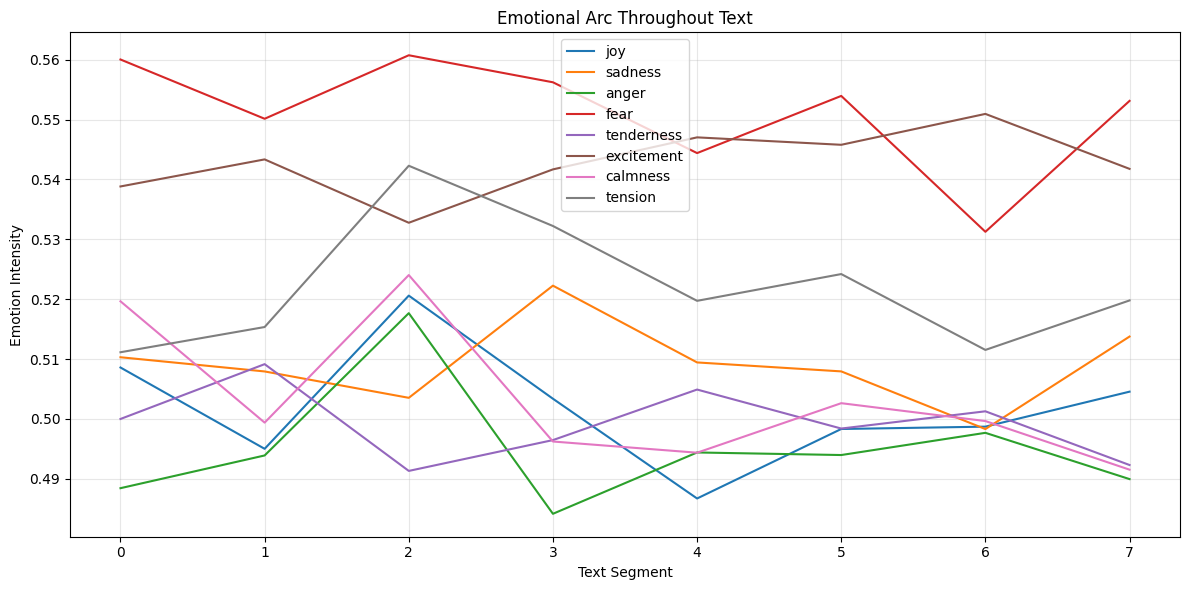

Mapping emotions to music parameters...
Applying temporal coherence model...
Generating music prompts...
Generating audio for each segment...

Generating music for segment 1/8:
Text: The old mansion stood silent against the stormy sk...
Prompt: A ambient, peaceful piece in major key at 114 BPM, evoking feelings of calmness and tenderness and anger. Featuring piano and strings with subtle woodwinds. 

Generating music for segment 2/8:
Text: and dance echoed through empty halls. A lone figur...
Prompt: A suspenseful, atmospheric piece in major key at 114 BPM, evoking feelings of calmness and joy and fear. Featuring piano and strings with subtle woodwinds. 

Generating music for segment 3/8:
Text: watching raindrops trace patterns like tears upon ...
Prompt: A suspenseful, atmospheric piece in major key at 119 BPM, evoking feelings of anger and fear and excitement. Featuring full orchestra with prominent brass and percussion. 

Generating music for segment 4/8:
Text: had been home, but to


Generated Music Prompts:

Prompt 1:
A ambient, peaceful piece in major key at 114 BPM, evoking feelings of calmness and tenderness and anger. Featuring piano and strings with subtle woodwinds. 

Prompt 2:
A suspenseful, atmospheric piece in major key at 114 BPM, evoking feelings of calmness and joy and fear. Featuring piano and strings with subtle woodwinds. 

Prompt 3:
A suspenseful, atmospheric piece in major key at 119 BPM, evoking feelings of anger and fear and excitement. Featuring full orchestra with prominent brass and percussion. 

Prompt 4:
A ambient, peaceful piece in major key at 117 BPM, evoking feelings of excitement and calmness and joy. Featuring piano and strings with subtle woodwinds. 

Prompt 5:
A suspenseful, atmospheric piece in major key at 115 BPM, evoking feelings of tension and calmness and tenderness. Featuring piano and strings with subtle woodwinds. 

Prompt 6:
A suspenseful, atmospheric piece in major key at 114 BPM, evoking feelings of calmness and tension

In [12]:
def main():
    """Main function to demonstrate the emotion-aware music generation system"""
    # Example literary text
    literary_text = """
    The old mansion stood silent against the stormy sky. Inside, memories of
    laughter and dance echoed through empty halls. A lone figure stood at the
    window, watching raindrops trace patterns like tears upon the glass.
    For years this place had been home, but tomorrow it would belong to strangers.
    As night fell, the wind picked up, rattling the windows like impatient ghosts.
    The figure lit a candle, its warm glow a defiant stand against the gathering darkness.
    Morning came with unexpected brightness, sunlight streaming through windows,
    illuminating dust motes dancing in the air. Perhaps, thought the figure with a smile,
    endings could also be beginnings.
    """

    print("Starting emotion-aware music generation process...")
    print(f"Input text: {literary_text[:100]}...")

    # Process text and generate music
    result = process_text_and_generate_music(literary_text, num_segments=8)

    # Play the generated music
    play_generated_music(result["audio"], result["sample_rate"])

    # Print the generated prompts
    print("\nGenerated Music Prompts:")
    for i, prompt in enumerate(result["prompts"]):
        print(f"\nPrompt {i+1}:")
        print(prompt)

    return result

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()